In [3]:
import os
import numpy as np
from pycbc.waveform import get_td_waveform
from pycbc.psd import aLIGOZeroDetHighPower
from pycbc.filter import sigma
from pycbc.types import FrequencySeries
from pycbc import noise, distributions
from gwpy.timeseries import TimeSeries
from tqdm import tqdm
from astropy import units as u

# === Parameters ===
fs = 4096
duration = 4.0
delta_t = 1.0 / fs
tsamples = int(fs * duration)
flow = 30.0
target_snr_range = (8, 12)
mass_dist = distributions.Uniform(mass1=(10, 50), mass2=(10, 50))
injection_times = [1.0, 1.5, 2.0, 2.5, 3.0]

# === Directories ===
base_dir = "./combined-dataset/"
dirs = {
    "real_noise": os.path.join(base_dir, "real-noise"),
    "real_signal_injected": os.path.join(base_dir, "real-signal-injected"),
    "real_signal": os.path.join("real-signal"),
    "synthetic_noise": os.path.join(base_dir, "synthetic-noise"),
    "synthetic_signal_injected": os.path.join(base_dir, "synthetic-signal-injected"),
    "synthetic_signal": os.path.join("synthetic-signal")
}
for d in dirs.values():
    os.makedirs(d, exist_ok=True)

# === Load Real Noise ===
real_noise_dir = "./dataset/real-noise-files/"
real_files = sorted([f for f in os.listdir(real_noise_dir) if f.endswith(".txt")])

# === PSD Template ===
delta_f = 1.0 / duration
flen = int(2048 / delta_f) + 1
psd_template = aLIGOZeroDetHighPower(flen, delta_f, flow)
psd_template[psd_template == 0] = 1e-40
psd_template = FrequencySeries(psd_template, delta_f=delta_f)

# === Real Noise Injection ===
for idx, file in tqdm(enumerate(real_files), total=len(real_files), desc="Real Noise Processing"):
    try:
        noise_path = os.path.join(real_noise_dir, file)
        noise_ts = TimeSeries.read(noise_path)
        noise_ts = noise_ts.taper('leftright', 0.5).bandpass(35, 350).crop(noise_ts.t0.value, noise_ts.t0.value + duration)
        noise_pycbc = noise_ts.to_pycbc()

        m1, m2 = mass_dist.rvs(size=1)[0]
        if m1 < m2:
            m1, m2 = m2, m1
        hp, _ = get_td_waveform(approximant="SEOBNRv2", mass1=m1, mass2=m2, delta_t=delta_t, f_lower=40.0,
                                 distance=1, inclination=np.random.uniform(0, np.pi),
                                 spin1z=np.random.uniform(-0.99, 0.99),
                                 spin2z=np.random.uniform(-0.99, 0.99))

        ht = hp.to_frequencyseries()
        psd = aLIGOZeroDetHighPower(len(ht), ht.delta_f, flow)
        psd[psd == 0] = 1e-40
        psd = FrequencySeries(psd, delta_f=ht.delta_f)

        snr = sigma(ht, psd=psd, low_frequency_cutoff=40.0)
        if not np.isfinite(snr) or snr == 0:
            continue

        target_snr = np.random.uniform(*target_snr_range)
        hp *= target_snr / snr

        signal_ts = TimeSeries.from_pycbc(hp)
        signal_ts.t0 = noise_ts.t0 + np.random.choice(injection_times) * u.second
        injected_ts = noise_ts.inject(signal_ts)

        noise_ts.write(os.path.join(dirs["real_noise"], f"real_noise_{idx}.txt"))
        signal_ts.write(os.path.join(dirs["real_signal"], f"real_signal_{idx}.txt"))
        injected_ts.write(os.path.join(dirs["real_signal_injected"], f"real_injected_{idx}.txt"))

    except Exception as e:
        print(f"⚠️ Real [{idx}] skipped: {e}")

# === Synthetic Noise Injection ===
for idx in tqdm(range(len(real_files)), desc="Synthetic Noise Generation"):
    try:
        noise_data = noise.noise_from_psd(tsamples, delta_t, psd_template)
        noise_ts = TimeSeries.from_pycbc(noise_data)
        noise_ts = noise_ts.taper('leftright', 0.5).bandpass(35, 350)

        m1, m2 = mass_dist.rvs(size=1)[0]
        if m1 < m2:
            m1, m2 = m2, m1
        hp, _ = get_td_waveform(approximant="SEOBNRv2", mass1=m1, mass2=m2, delta_t=delta_t, f_lower=40.0,
                                 distance=1, inclination=np.random.uniform(0, np.pi),
                                 spin1z=np.random.uniform(-0.99, 0.99),
                                 spin2z=np.random.uniform(-0.99, 0.99))

        ht = hp.to_frequencyseries()
        psd = aLIGOZeroDetHighPower(len(ht), ht.delta_f, flow)
        psd[psd == 0] = 1e-40
        psd = FrequencySeries(psd, delta_f=ht.delta_f)

        snr = sigma(ht, psd=psd, low_frequency_cutoff=40.0)
        if not np.isfinite(snr) or snr == 0:
            continue

        target_snr = np.random.uniform(*target_snr_range)
        hp *= target_snr / snr

        signal_ts = TimeSeries.from_pycbc(hp)
        signal_ts.t0 = np.random.choice(injection_times)
        injected_ts = noise_ts.inject(signal_ts)

        noise_ts.write(os.path.join(dirs["synthetic_noise"], f"synthetic_noise_{idx}.txt"))
        signal_ts.write(os.path.join(dirs["synthetic_signal"], f"synthetic_signal_{idx}.txt"))
        injected_ts.write(os.path.join(dirs["synthetic_signal_injected"], f"synthetic_injected_{idx}.txt"))

    except Exception as e:
        print(f"⚠️ Synthetic [{idx}] skipped: {e}")


Synthetic Noise Generation: 100%|██████████| 4480/4480 [42:41<00:00,  1.75it/s]


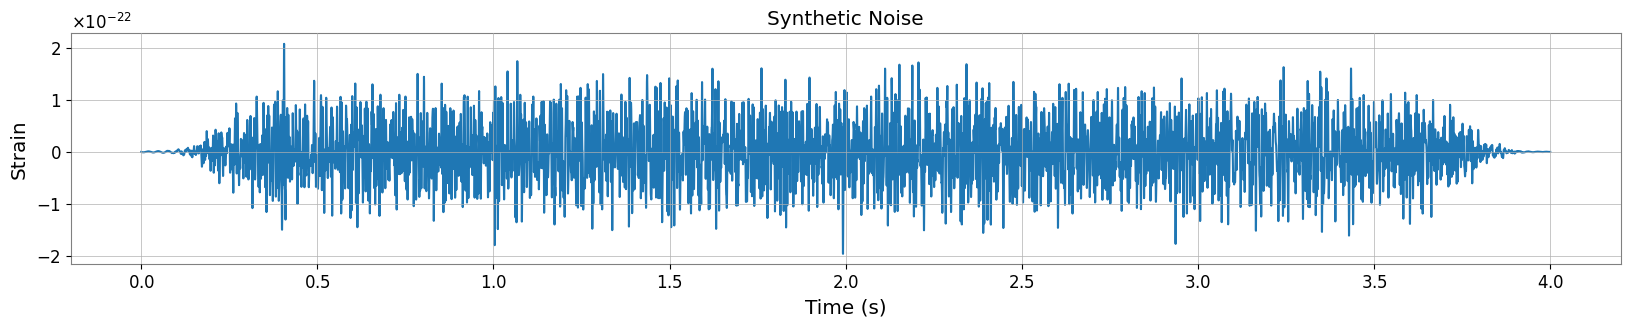

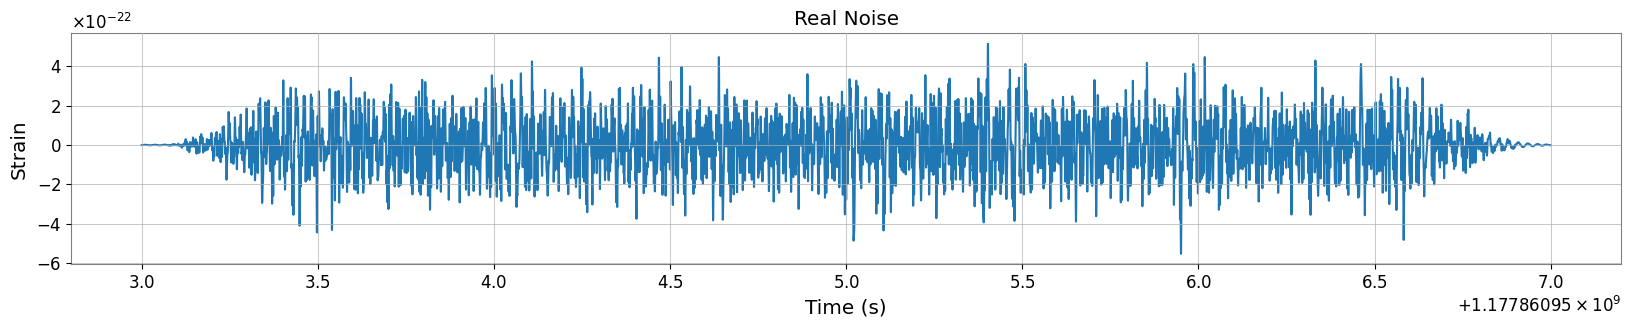

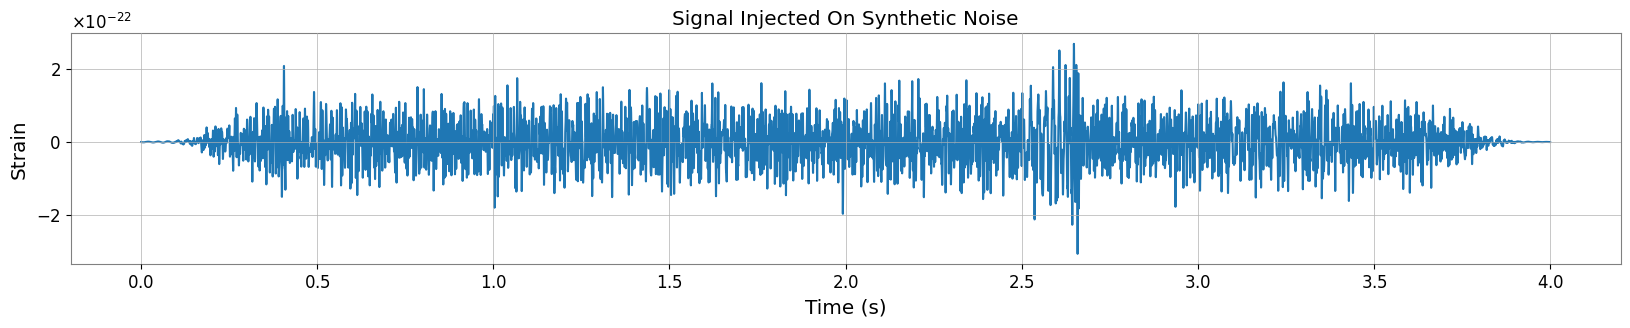

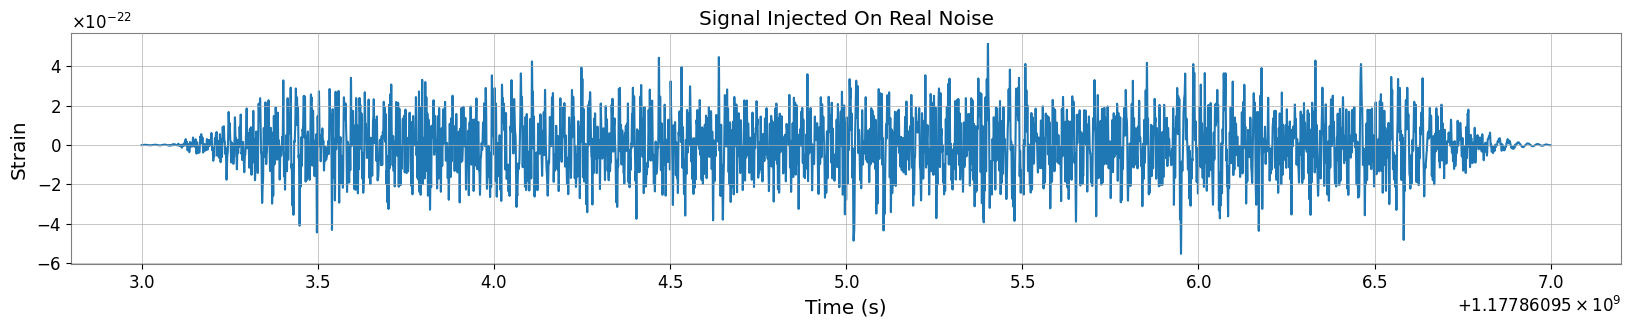

In [2]:
import matplotlib.pyplot as plt
from gwpy.timeseries import TimeSeries as GTimeSeries

ts = GTimeSeries.read('./combined-dataset/synthetic-noise/synthetic_noise_5.txt')

plt.figure(figsize=(20, 3))
plt.plot(ts.times.value, ts.value)
plt.title("Synthetic Noise")
plt.xlabel("Time (s)")
plt.ylabel("Strain")
plt.grid(True)
plt.show()

ts = GTimeSeries.read('./combined-dataset/real-noise/real_noise_5.txt')

plt.figure(figsize=(20, 3))
plt.plot(ts.times.value, ts.value)
plt.title("Real Noise")
plt.xlabel("Time (s)")
plt.ylabel("Strain")
plt.grid(True)
plt.show()


ts = GTimeSeries.read('./combined-dataset/synthetic-signal-injected/synthetic_injected_5.txt')

plt.figure(figsize=(20, 3))
plt.plot(ts.times.value, ts.value)
plt.title("Signal Injected On Synthetic Noise")
plt.xlabel("Time (s)")
plt.ylabel("Strain")
plt.grid(True)
plt.show()


ts = GTimeSeries.read('./combined-dataset/real-signal-injected/real_injected_5.txt')

plt.figure(figsize=(20, 3))
plt.plot(ts.times.value, ts.value)
plt.title("Signal Injected On Real Noise")
plt.xlabel("Time (s)")
plt.ylabel("Strain")
plt.grid(True)
plt.show()

In [17]:
import csv
import pandas as pd

In [18]:
#Merging the injected signal on real noise into single CSV file
path = "./combined-dataset/real-signal-injected/"
files= os.listdir(path)
f = open("./combined-dataset/real-signal-injected.csv", 'w')
cw = csv.writer(f)

for i in tqdm(files):
    df = pd.read_csv(path+i,sep = ' ', header=None)
    c = df[:][1]
    cw.writerow(c)
f.close()

100%|██████████| 4480/4480 [04:33<00:00, 16.37it/s]


In [19]:
#Merging the injected signal on synthetic noise into single CSV file
path = "./combined-dataset/synthetic-signal-injected/"
files= os.listdir(path)
f = open("./combined-dataset/synthetic-signal-injected.csv", 'w')
cw = csv.writer(f)

for i in tqdm(files):
    df = pd.read_csv(path+i,sep = ' ', header=None)
    c = df[:][1]
    cw.writerow(c)
f.close()

100%|██████████| 4480/4480 [04:08<00:00, 18.05it/s]


In [20]:
#Merging the synthetic noise into single CSV file
path = "./combined-dataset/synthetic-noise/"
files= os.listdir(path)
f = open("./combined-dataset/synthetic-noise.csv", 'w')
cw = csv.writer(f)

for i in tqdm(files):
    df = pd.read_csv(path+i,sep = ' ', header=None)
    c = df[:][1]
    cw.writerow(c)
f.close()

100%|██████████| 4480/4480 [02:38<00:00, 28.22it/s]


In [21]:
#Merging the real noise into single CSV file
path = "./combined-dataset/real-noise/"
files= os.listdir(path)
f = open("./combined-dataset/real-noise.csv", 'w')
cw = csv.writer(f)

for i in tqdm(files):
    df = pd.read_csv(path+i,sep = ' ', header=None)
    c = df[:][1]
    cw.writerow(c)
f.close()

100%|██████████| 4480/4480 [03:14<00:00, 23.03it/s]


In [78]:
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler

# Load CSVs (merge real+synthetic)
signal_real = pd.read_csv("./combined-dataset/real-signal-injected.csv", header=None).astype(float)
signal_syn = pd.read_csv("./combined-dataset/synthetic-signal-injected.csv", header=None).astype(float)
noise_real = pd.read_csv("./combined-dataset/real-noise.csv", header=None).astype(float)
noise_syn = pd.read_csv("./combined-dataset/synthetic-noise.csv", header=None).astype(float)

signal_real["label"] = 1
signal_syn["label"] = 1
noise_real["label"] = 0
noise_syn["label"] = 0

# Combine dataset (adjust ratio if needed)
train_data = pd.concat([signal_real, signal_syn, noise_real, noise_syn], axis=0)
train_data = shuffle(train_data, random_state=42)

X = train_data.iloc[:, :-1].values
y = train_data["label"].values.astype(np.float32)

# Normalize based on pure noise only
noise_all = pd.concat([noise_real, noise_syn], axis=0)
scaler = StandardScaler()
scaler.fit(noise_all.iloc[:, :-1])
X = scaler.transform(X)

# Expand for CNN input
X = np.expand_dims(X, axis=-1)


In [79]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv1D, BatchNormalization, ReLU,
                                     MaxPooling1D, Dropout, GlobalAveragePooling1D,
                                     Dense, Add)
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

def residual_block(x, filters, kernel_size=8, pool_size=4, dropout_rate=0.3):
    shortcut = x
    x = Conv1D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv1D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    # Residual connection
    x = Add()([shortcut, x]) if shortcut.shape[-1] == filters else x
    x = ReLU()(x)
    x = MaxPooling1D(pool_size=pool_size)(x)
    x = Dropout(dropout_rate)(x)
    return x

def build_best_cnn(input_shape=(16384, 1)):
    inputs = Input(shape=input_shape)

    # Initial Conv
    x = Conv1D(32, 16, padding='same', strides=1)(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling1D(pool_size=4)(x)

    # Residual Blocks
    x = residual_block(x, 64, 8, pool_size=4, dropout_rate=0.3)
    x = residual_block(x, 128, 8, pool_size=4, dropout_rate=0.3)
    x = residual_block(x, 256, 4, pool_size=4, dropout_rate=0.4)

    # Global feature aggregation
    x = Conv1D(512, 4, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = GlobalAveragePooling1D()(x)

    # Classifier
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

model = build_best_cnn()
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# === Evaluate ===
y_pred = model.predict(X_val).ravel()

Epoch 1/30
448/448 [==============================] - 51s 100ms/step - loss: 0.7137 - accuracy: 0.4979 - val_loss: 0.7185 - val_accuracy: 0.5003
Epoch 2/30
448/448 [==============================] - 42s 95ms/step - loss: 0.6913 - accuracy: 0.5309 - val_loss: 0.6312 - val_accuracy: 0.6049
Epoch 3/30
448/448 [==============================] - 42s 95ms/step - loss: 0.5387 - accuracy: 0.6836 - val_loss: 0.4780 - val_accuracy: 0.7140
Epoch 4/30
448/448 [==============================] - 42s 95ms/step - loss: 0.4143 - accuracy: 0.7415 - val_loss: 0.6939 - val_accuracy: 0.7201
Epoch 5/30
448/448 [==============================] - 42s 95ms/step - loss: 0.3911 - accuracy: 0.7531 - val_loss: 0.4199 - val_accuracy: 0.7355
Epoch 6/30
448/448 [==============================] - 42s 95ms/step - loss: 0.3733 - accuracy: 0.7709 - val_loss: 0.5181 - val_accuracy: 0.7461
Epoch 7/30
448/448 [==============================] - 48s 108ms/step - loss: 0.3661 - accuracy: 0.7781 - val_loss: 0.3837 - val_accurac

ROC AUC Score: 0.9532084562340561
              precision    recall  f1-score   support

         0.0       0.81      0.98      0.89      1792
         1.0       0.97      0.78      0.86      1792

    accuracy                           0.88      3584
   macro avg       0.89      0.88      0.87      3584
weighted avg       0.89      0.88      0.87      3584



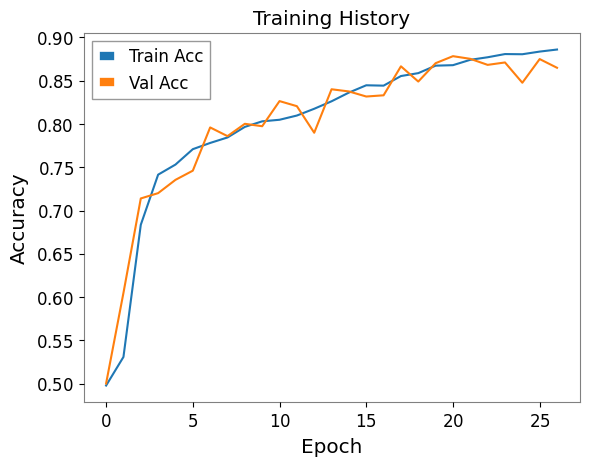

In [80]:
from sklearn.metrics import classification_report, roc_auc_score
print("ROC AUC Score:", roc_auc_score(y_val, y_pred))
print(classification_report(y_val, (y_pred > 0.5).astype(int)))

# === Plot Accuracy ===
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Training History')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

In [81]:
model.save("final_combined_cnn_model.h5")
np.save("scaler_mean_combined.npy", scaler.mean_)
np.save("scaler_scale_combined.npy", scaler.scale_)


/usr/local/lib/python3.8/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [63]:
import os
import csv
import pandas as pd
from gwosc.datasets import event_gps
from gwpy.timeseries import TimeSeries
from tqdm import tqdm

# ===========================
# PARAMETERS
# ===========================
bbh_events = [
    'GW150914','GW151012','GW151226','GW170104','GW170608','GW170729',
    'GW170809','GW170814','GW170818','GW170823','GW190408_181802',
    'GW190412','GW190413_052954','GW190413_134308','GW190421_213856',
    'GW190424_180648','GW190425','GW190503_185404','GW190512_180714',
    'GW190513_205428','GW190514_065416','GW190517_055101','GW190519_153544',
    'GW190521','GW190521_074359','GW190527_092055','GW190602_175927',
    'GW190620_030421','GW190630_185205','GW190701_203306','GW190706_222641',
    'GW190707_093326','GW190708_232457','GW190719_215514','GW190720_000836',
    'GW190727_060333','GW190728_064510','GW190731_140936','GW190803_022701',
    'GW190814','GW190828_063405','GW190828_065509','GW190909_114149',
    'GW190910_112807','GW190915_235702','GW190924_021846','GW190929_012149',
    'GW190930_133541'
]

output_dir = "./BBH/original-signals/"
#merged_csv = "./BBH/Original_BBH.csv"
os.makedirs(output_dir, exist_ok=True)

# ===========================
# DOWNLOAD AND PREPROCESS
# ===========================
for i in tqdm(range(len(bbh_events))):
    gps = event_gps(bbh_events[i])
    start = int(gps) - 15
    end = int(gps) + 15

    data = TimeSeries.fetch_open_data('L1', start, end)
    data.write(os.path.join(output_dir, bbh_events[i] + ".txt"))

100%|██████████| 48/48 [02:00<00:00,  2.51s/it]


In [70]:
input_dir = "./BBH/original-signals/"
output_dir = "./BBH/processed-signals/"
os.makedirs(output_dir, exist_ok=True)

for i in tqdm(range(len(bbh_events))):
    gps = event_gps(bbh_events[i])
    data = TimeSeries.read(input_dir + bbh_events[i]+".txt")
    data = data.whiten(4,2)
    data = data.bandpass(35, 350) 
    data = data.crop(gps - 2, gps + 2)
    data = data.taper('leftright', 0.5) 

    data.write(os.path.join(output_dir, bbh_events[i] + ".txt"))

100%|██████████| 48/48 [00:08<00:00,  5.76it/s]


In [71]:
path = "./BBH/processed-signals/"
files= os.listdir(path)
f = open("./BBH/processed.csv", 'w')
cw = csv.writer(f)

for i in tqdm(files):
    df = pd.read_csv(path+i,sep = ' ', header=None)
    c = df[:][1]
    cw.writerow(c)
f.close()

100%|██████████| 48/48 [00:00<00:00, 51.40it/s]


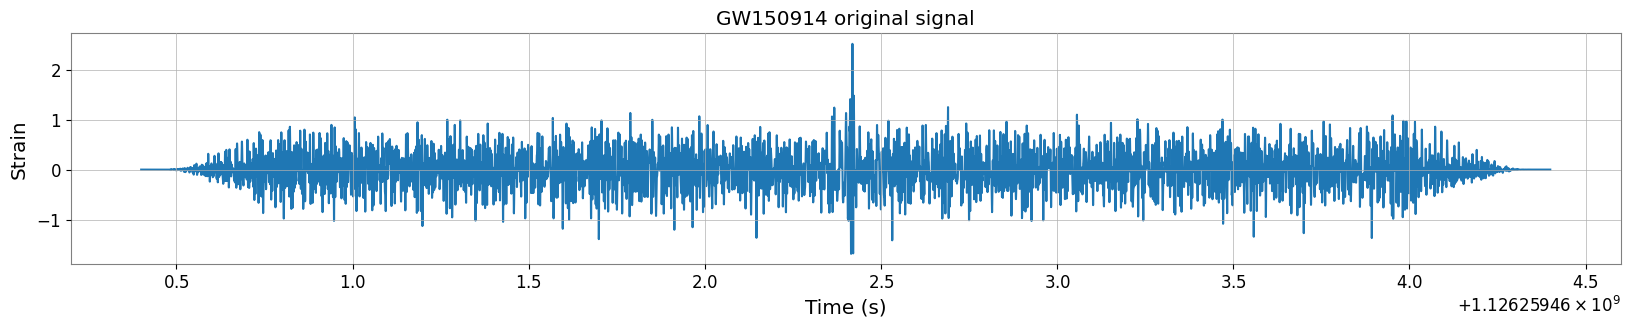

In [82]:
ts = GTimeSeries.read('./BBH/processed-signals/GW150914.txt')

plt.figure(figsize=(20, 3))
plt.plot(ts.times.value, ts.value)
plt.title("GW150914 original signal")
plt.xlabel("Time (s)")
plt.ylabel("Strain")
plt.grid(True)
plt.show()

In [44]:
import os
import csv
import numpy as np
import pandas as pd
from gwpy.timeseries import TimeSeries
from tqdm import tqdm

# Choose unseen run (e.g., O3a)
start, end = 1238166018, 1253977218  # O3a for L1
detector = 'L1'
duration = 4
sample_rate = 4096
n_segments = 48

output_dir = "./BBH/original-noise-unseen/"
merged_csv = "./BBH/Original_Noise_Unseen.csv"
os.makedirs(output_dir, exist_ok=True)

np.random.seed(123)
start_times = np.random.randint(start, end-duration, size=n_segments*3)

downloaded = 0
for gps_start in tqdm(start_times, desc="Downloading unseen noise"):
    if downloaded >= n_segments:
        break
    try:
        ts = TimeSeries.fetch_open_data(detector, gps_start, gps_start+duration, sample_rate=sample_rate)
        ts = ts.detrend('linear').bandpass(35, 350).taper('leftright', 0.5)
        if len(ts) != sample_rate * duration:
            continue
        ts.write(os.path.join(output_dir, f"noise_{downloaded}.txt"))
        downloaded += 1
    except:
        continue

✅ Downloaded 48 unseen noise segments.
✅ Saved unseen noise dataset: ./BBH/Original_Noise_Unseen.csv


In [45]:
# Merge CSV
files = sorted(os.listdir(output_dir))
with open(merged_csv, 'w', newline='') as f:
    cw = csv.writer(f)
    for fname in files:
        df = pd.read_csv(os.path.join(output_dir, fname), sep=' ', comment='#', header=None)
        strain_col = df.dropna(axis=1).iloc[:, -1]
        if len(strain_col) == sample_rate * duration:
            cw.writerow(strain_col)

print(f"✅ Saved unseen noise dataset: {merged_csv}")

✅ Saved unseen noise dataset: ./BBH/Original_Noise_Unseen.csv


In [83]:
import pandas as pd

data_BBH_df = pd.read_csv("./BBH/processed.csv", header=None)
X = data_BBH_df.values.astype(float)

print(len(data_BBH_df.index))

y = [1 for i in range(len(data_BBH_df.index))]

X = scaler.transform(X)

X = np.expand_dims(X, axis=-1)
print(X.shape)

48
(48, 16384, 1)


In [84]:
pred = model.predict(X)
y_pred = (pred.ravel() > 0.5).astype(int)
correct = np.sum(y_pred == y)
acc = (correct / len(y)) * 100

print(f"Total no. of data samples: {len(y)}")
print(f"No. of correct predictions: {correct}")
print(f"Accuracy: {acc:.2f}%")


2/2 [==============================] - 1s 358ms/step
Total no. of data samples: 48
No. of correct predictions: 48
Accuracy: 100.00%


In [85]:
data_BBH_df = pd.read_csv("./BBH/Original_Noise_Unseen.csv", header=None)
X = data_BBH_df.values.astype(float)

print(len(data_BBH_df.index))

y = [0 for i in range(len(data_BBH_df.index))]

X = scaler.transform(X)

X = np.expand_dims(X, axis=-1)
print(X.shape)

48
(48, 16384, 1)


In [86]:
pred = model.predict(X)
y_pred = (pred.ravel() > 0.5).astype(int)
correct = np.sum(y_pred == y)
acc = (correct / len(y)) * 100

print(f"Total no. of data samples: {len(y)}")
print(f"No. of correct predictions: {correct}")
print(f"Accuracy: {acc:.2f}%")


2/2 [==============================] - 0s 301ms/step
Total no. of data samples: 48
No. of correct predictions: 47
Accuracy: 97.92%
